1. Build 6822 rotation model and use to mask out 6822 from the GBT cube
2. Build local covariance matrix with \texttt{CloudClean.jl} % https://github.com/andrew-saydjari/CloudClean.jl
3. Use pixel-wise infilling drawing from the covariance matrix to create a Galactic HI only GBT cube, and subtract the infilled version from the original to create a 6822 only GBT cube.
4. Mask by-hand the few Galactic \hi\ structures in the VLA cube
5. then feather together.

In [73]:
%matplotlib inline

In [74]:
from spectral_cube import SpectralCube
from reproject.mosaicking import find_optimal_celestial_wcs

from astropy.coordinates import SkyCoord

from pathlib import Path

In [75]:
from galaxies import Galaxy

In [76]:
sd_data_path = Path("/reduction10/erickoch/LGLBS/hi_feathering/")

In [77]:
gbt_cube = SpectralCube.read(sd_data_path / "NGC6822-center_cube.fits")
gbt_cube = gbt_cube.with_spectral_unit(u.km/u.s, 'radio')

gbt_cube

SpectralCube with shape=(389, 128, 128) and unit=K:
 n_x:    128  type_x: GLON-SFL  unit_x: deg    range:    23.357304 deg:   27.305497 deg
 n_y:    128  type_y: GLAT-SFL  unit_y: deg    range:   -20.249722 deg:  -16.545556 deg
 n_s:    389  type_s: VRAD      unit_s: km / s  range:     -499.757 km / s:     499.931 km / s

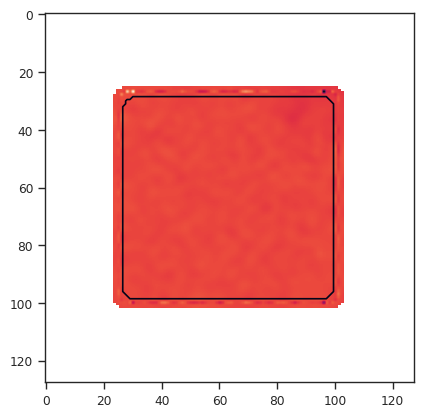

In [78]:
# Add an edge mask to remove the noisiest edge regions

gbt_edge_mask = nd.binary_erosion(np.isfinite(gbt_cube[0].value),
                                  np.ones((3, 3), dtype=bool),
                                  iterations=4)

plt.imshow(gbt_cube[0].value)
plt.contour(gbt_edge_mask)

gbt_cube = gbt_cube.with_mask(gbt_edge_mask)

In [79]:
# Reproject into ICRS 
new_wcs_celestial, new_shape = find_optimal_celestial_wcs(gbt_cube[0].hdu, frame='icrs', projection='SIN')
new_wcs_celestial

new_hdr = new_wcs_celestial.to_header()
new_hdr['WCSAXES'] = 3

new_hdr['NAXIS'] = 3
new_hdr['NAXIS1'] = new_shape[1]
new_hdr['NAXIS2'] = new_shape[0]

# Add the spectral information back
new_hdr['NAXIS3'] = gbt_cube.shape[0]

for this_key in ['CTYPE3', 'CRPIX3', 'CDELT3', 'CUNIT3', 'CRVAL3', 'SPECSYS', 'RESTFRQ', 'MJDREF']:
    new_hdr[this_key] = gbt_cube.header[this_key]
    
new_hdr

WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =      634.06953797952 / Pixel coordinate of reference point            
CRPIX2  =      370.19322610204 / Pixel coordinate of reference point            
CDELT1  =   -0.029166666666667 / [deg] Coordinate increment at reference point  
CDELT2  =    0.029166666666667 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---SIN'           / Right ascension, orthographic/synthesis project
CTYPE2  = 'DEC--SIN'           / Declination, orthographic/synthesis projection 
CRVAL1  =       279.3847684259 / [deg] Coordinate value at reference point      
CRVAL2  =     -6.7464206161817 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =     -6.74642061618

In [80]:
gbt_cube_icrs = gbt_cube.reproject(new_hdr).minimal_subcube()

In [81]:
this_galaxy = Galaxy('NGC6822')

# Adopt galaxy parameters from Namumba+2017 (https://ui.adsabs.harvard.edu/abs/2017MNRAS.472.3761N/abstract)
this_galaxy.vsys = -55 * u.km/u.s
this_galaxy.inclination = 66 * u.deg
this_galaxy.position_angle = 118 * u.deg


this_galaxy.center_position = SkyCoord("19h44m58.0s −14d48m11.9s")


In [82]:
this_galaxy.distance

<Quantity 0.50999999 Mpc>

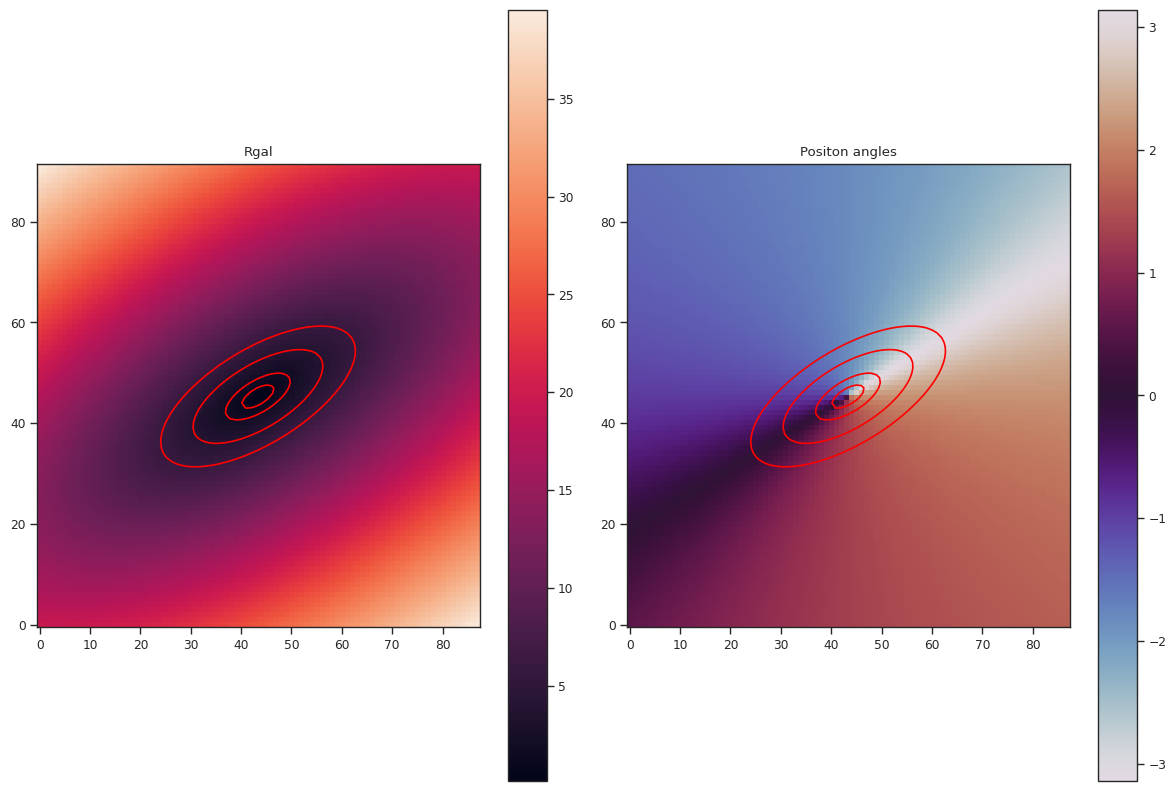

In [83]:
rgal = this_galaxy.radius(header=gbt_cube_icrs.header).to(u.kpc)
pas = this_galaxy.position_angles(header=gbt_cube_icrs.header)

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.title("Rgal")
plt.imshow(rgal.value, origin='lower')
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6], colors='red')

plt.subplot(122)
plt.title("Positon angles")
plt.imshow(pas.value, origin='lower', cmap='twilight')
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6], colors='red')

plt.tight_layout()

Showing channel 215


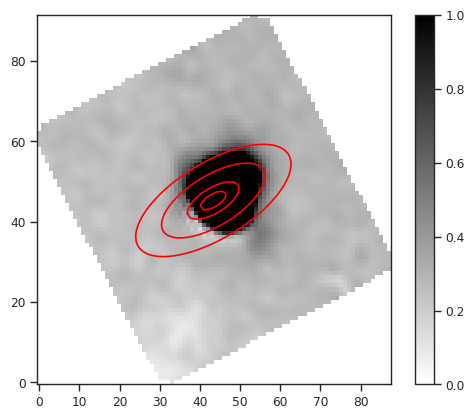

In [84]:
# Visualize the central channel:
this_chan = gbt_cube_icrs.closest_spectral_channel(this_galaxy.vsys)
print(f"Showing channel {this_chan}")

plt.imshow(gbt_cube_icrs[this_chan].value, origin='lower', vmin=0, vmax=1, cmap='binary')
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6], colors='red')


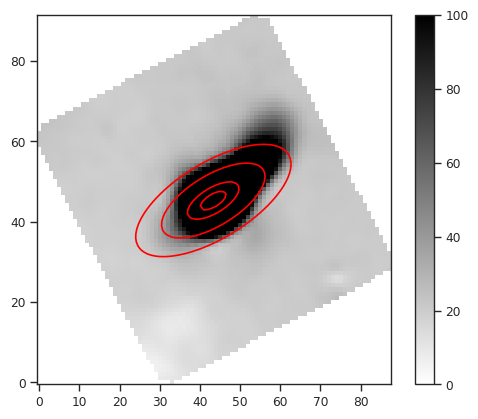

In [85]:
# And integrate over the central region to make sure we have the correct orientation and such:

mom0 = gbt_cube_icrs.spectral_slab(this_galaxy.vsys - 40 * u.km / u.s,
                                  this_galaxy.vsys + 40 * u.km / u.s).moment0()

plt.imshow(mom0.value, origin='lower', vmin=0, vmax=100, cmap='binary')
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6], colors='red')

### Implement the KAT-7 rotation curve model and create a velocity surface.

[67.24673908  1.65234927] [[8.97668458 0.46733253]
 [0.46733253 0.02822895]]


Text(0.5, 0, 'Rgal (kpc)')

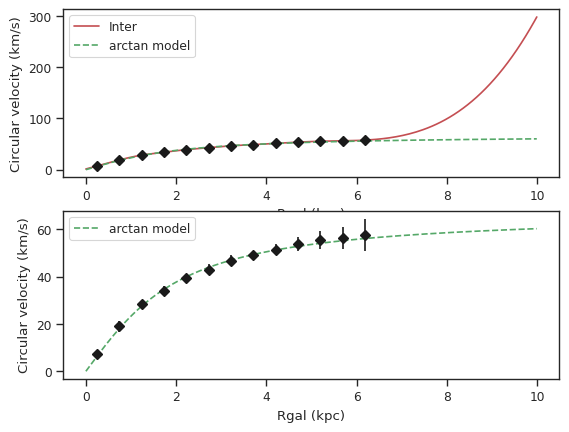

In [86]:
from scipy.interpolate import CubicSpline

radii = np.arange(100, 2501, 200) * u.arcsec
radii_phys = radii.to(u.rad).value * this_galaxy.distance.to(u.kpc).value



vcirc = np.array([7.2, 19.0, 28.4, 34.0, 39.2, 42.9, 46.6, 48.9, 51.4, 53.8, 55.5, 56.3, 57.7])
vcirc_err = np.array([1.6, 2.3, 1.9, 2.1, 1.6, 2.4, 2.3, 2.1, 2.5, 2.9, 3.8, 4.6, 6.8])

# Make a smoothly interpolated function
vcirc_interp = CubicSpline(radii_phys, vcirc)

def model_func(r, *pars):
    '''
    arctan from Courteau 1997
    '''
    v0, rt = pars
    return (2 * v0 / np.pi) * np.arctan(r / rt)

from scipy.optimize import curve_fit
pars, pcov = curve_fit(model_func, radii_phys, vcirc, sigma=vcirc_err,
                       absolute_sigma=True, 
                       p0=(60., 3.))

print(pars, pcov)

vcirc_model = lambda r: model_func(r, *pars)

radii_bins = np.arange(0, 10, 
                       np.diff(radii_phys[:2])[0] / 10.)

ax=plt.subplot(211)
plt.errorbar(radii_phys, vcirc, yerr=vcirc_err, fmt='kD')
plt.plot(radii_bins, vcirc_interp(radii_bins), 'r-', label='Inter')
plt.plot(radii_bins, vcirc_model(radii_bins), 'g--', label='arctan model')
plt.legend()

plt.ylabel("Circular velocity (km/s)")
plt.xlabel("Rgal (kpc)")


plt.subplot(212, sharex=ax)
plt.errorbar(radii_phys, vcirc, yerr=vcirc_err, fmt='kD')
plt.plot(radii_bins, vcirc_model(radii_bins), 'g--', label='arctan model')
plt.legend()

plt.ylabel("Circular velocity (km/s)")
plt.xlabel("Rgal (kpc)")


The arctan model is a good representation of the rotation curve point and extrapolates cleanly to moderately larger radii.

### Generate a flat 3D rotation model

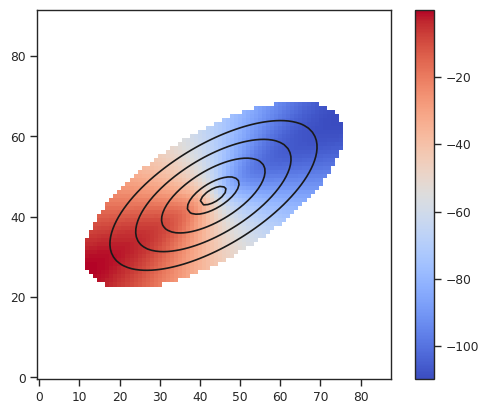

In [87]:
vsurf = vcirc_model(rgal.to(u.kpc).value) * np.sin(this_galaxy.inclination) * np.cos(pas) * u.km / u.s + this_galaxy.vsys

# Remove large values where the interpolation explodes
vsurf[rgal.value >= 10.] = np.NaN

plt.imshow(vsurf.value, origin='lower', cmap='coolwarm')
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6, 8], colors='k')


0.029166666666667 deg


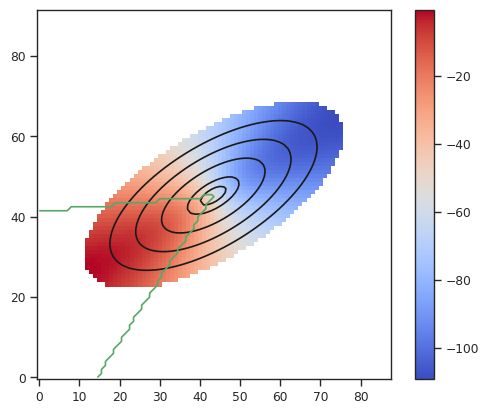

In [213]:
# Convolve by the gbt beam:

from astropy.convolution import convolve_fft

gbt_beam = gbt_cube.beam
pixscale = np.abs(gbt_cube_icrs.header['CDELT1'] * u.deg)
print(pixscale)

vsurf = vcirc_model(rgal.to(u.kpc).value) * np.sin(this_galaxy.inclination) * np.cos(pas) * u.km / u.s + this_galaxy.vsys
vsurf_conv = convolve_fft(vsurf, gbt_beam.as_kernel(pixscale))
vsurf_conv[rgal.value >= 10.] = np.NaN

plt.imshow(vsurf_conv.value, origin='lower', cmap='coolwarm')
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6, 8], colors='k')

pa_mask = np.logical_and(pas.value > -0.85, pas.value < 0.85)
plt.contour(pa_mask, colors='g')


In [290]:
ngc6822_mask = np.zeros(gbt_cube_icrs.shape, dtype=bool)

gbt_beam = gbt_cube.beam
pixscale = (gbt_cube_icrs.header['CDELT1'] * u.deg)
print(pixscale)
gbt_beam_kernel = gbt_beam.as_tophat_kernel(pixscale).array

gbt_beam_kernel_small = gbt_beam.as_tophat_kernel(pixscale * 0.25).array


# vel_width = np.abs(np.diff(gbt_cube_icrs.spectral_axis[:2])[0])
vel_width = 40 * u.km / u.s
print(vel_width)

vel_cent_mask = 100 * u.km / u.s

for idx, vel_cent in enumerate(gbt_cube_icrs.spectral_axis):
    # within_vel = np.logical_and(vsurf > vel_cent - 0.5 * vel_width,
    #                             vsurf <= vel_cent + 0.5 * vel_width)

    within_vel = np.logical_and(vsurf_conv > vel_cent - 0.5 * vel_width,
                                vsurf_conv <= vel_cent + 0.5 * vel_width)

    # There's some residual (lagging?) emission beyond the mask along the major axis
    # near the center.

    # Keep the mask smaller near the brightest Galactic HI.
    if vel_cent <= 20 * u.km / u.s and vel_cent >= -5 * u.km / u.s:
        # Add an extra "chunk" to account for where there's excess emission along the major axis in the redshifted limb
        # this is to limit the mask size to keep more information on the Galactic HI foreground
        pa_mask = np.logical_and(pas.value > -0.75, pas.value < 0.75)
        pa_mask = np.logical_and(pa_mask, rgal.value < 8.)
        within_vel = np.logical_or(within_vel, pa_mask)
        within_vel = nd.binary_dilation(within_vel, np.ones((3, 3), bool), iterations=2)
        
    elif vel_cent <= 40 * u.km / u.s and vel_cent >= 20 * u.km / u.s:
        pa_mask = np.logical_and(pas.value > -1, pas.value < 1)
        pa_mask = np.logical_and(pa_mask, rgal.value < 8.)
        within_vel = pa_mask
    # Try applying a radial map to get all edge emission outside of the brightest Galactic HI velocity range
    elif np.any(within_vel) and vel_cent >= this_galaxy.vsys - vel_cent_mask and vel_cent <= this_galaxy.vsys + vel_cent_mask:
        within_vel = np.logical_or(within_vel, rgal.value <= 8)
    
        within_vel = nd.binary_dilation(within_vel, gbt_beam_kernel, iterations=1)
    else:
        within_vel = nd.binary_dilation(within_vel, gbt_beam_kernel, iterations=1)
    
    ngc6822_mask[idx] = within_vel

-0.029166666666667 deg
40.0 km / s


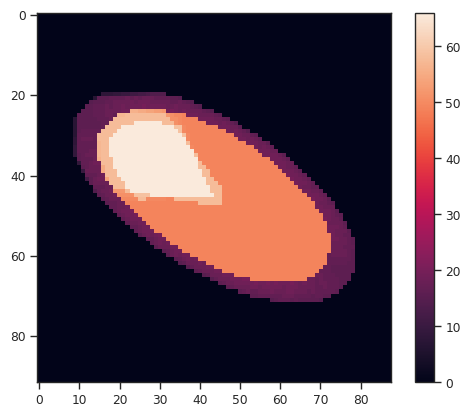

In [291]:
plt.imshow(ngc6822_mask.sum(0))
plt.colorbar()

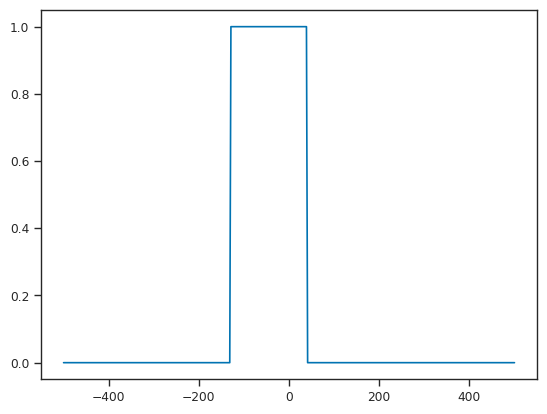

In [292]:
plt.plot(gbt_cube_icrs.spectral_axis.value, ngc6822_mask.any(axis=(1, 2)))

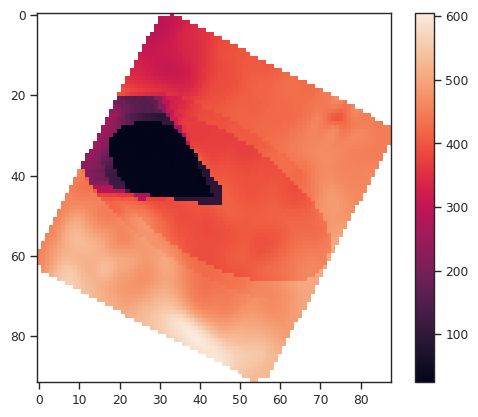

In [293]:
# gbt_cube_icrs.with_mask(~ngc6822_mask).max(0).quicklook()
gbt_cube_icrs.with_mask(~ngc6822_mask).moment0().quicklook()

plt.colorbar()

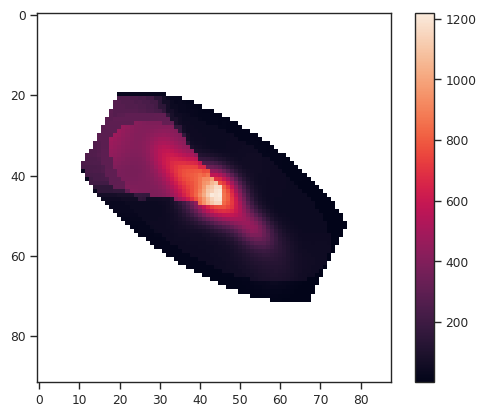

In [294]:
# gbt_cube_icrs.with_mask(ngc6822_mask).max(0).quicklook()
gbt_cube_icrs.with_mask(ngc6822_mask).moment0().quicklook()
plt.colorbar()

The masking has been fairly successful. We're clearly incorporating some Galactic HI emission in the redshifted half of NGC6822, but that's OK as it's where the infill will be most important!

Visualize the central channel again with the mask applied

In [295]:

gbt_cube_icrs_no6822 = gbt_cube_icrs.with_mask(~ngc6822_mask)

Showing channel 215


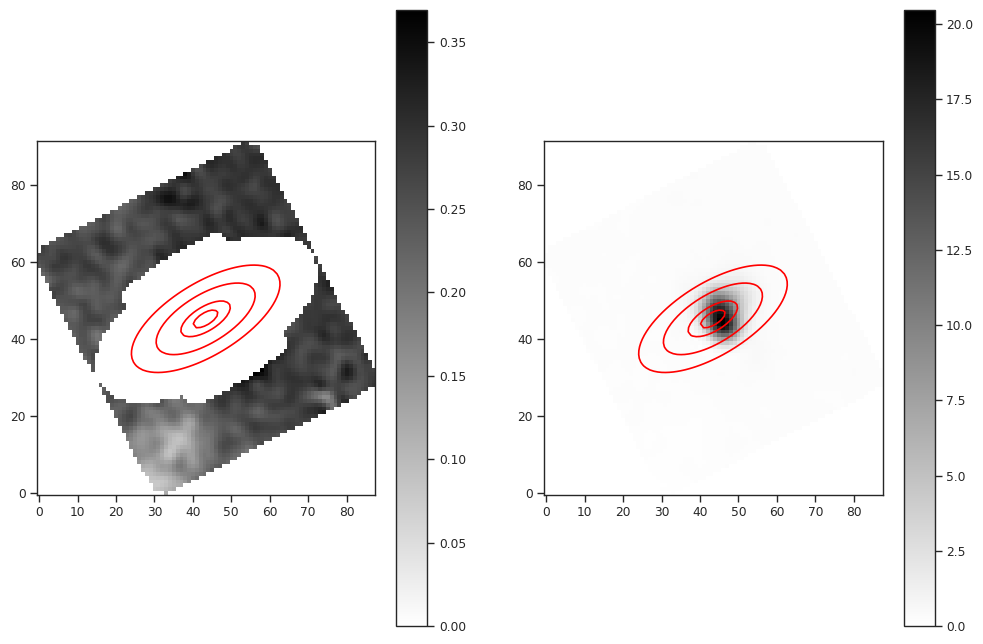

In [296]:
# Visualize the central channel:
this_chan = gbt_cube_icrs_no6822.closest_spectral_channel(this_galaxy.vsys) + 0
print(f"Showing channel {this_chan}")

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.imshow(gbt_cube_icrs_no6822[this_chan].value, origin='lower', vmin=0, cmap='binary')#, vmax=1, )
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6], colors='red')

plt.subplot(122)
plt.imshow(gbt_cube_icrs[this_chan].value, origin='lower', vmin=0, cmap='binary')#, vmax=1, )
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6], colors='red')


Showing channel 185
23.275978895324457 km / s


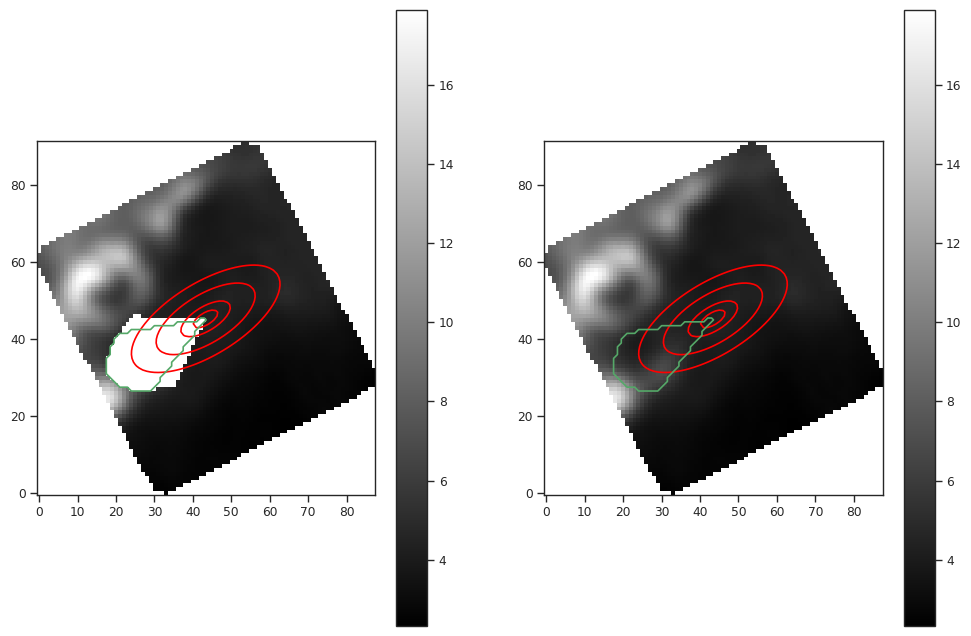

In [311]:
# Visualize the rest freq channel:
this_chan = gbt_cube_icrs_no6822.closest_spectral_channel(0 * u.km / u.s) + -9
print(f"Showing channel {this_chan}")
print(f"{gbt_cube_icrs_no6822.spectral_axis[this_chan]}")

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.imshow(gbt_cube_icrs_no6822[this_chan].value, origin='lower', cmap='binary_r')
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6], colors='red')
plt.contour(pa_mask, colors='g')

plt.subplot(122)
plt.imshow(gbt_cube_icrs[this_chan].value, origin='lower', cmap='binary_r')
plt.colorbar()
plt.contour(rgal.value, levels=[1, 2, 4, 6], colors='red')
plt.contour(pa_mask, colors='g')



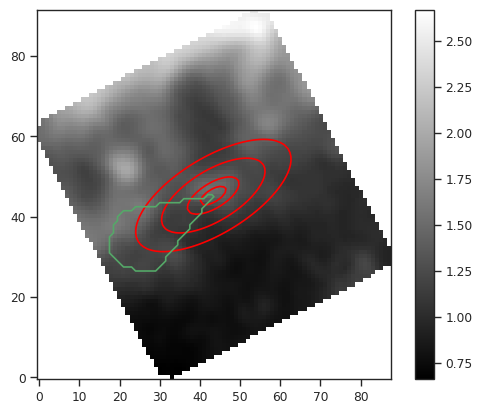

Ok this combination now looks quite clean!

In [312]:
# Save the set of cubes and masks:

is_finite_mask = np.isfinite(gbt_cube_icrs)

fits.PrimaryHDU((ngc6822_mask & is_finite_mask).astype(">i2"), gbt_cube_icrs.header).writeto(sd_data_path / "NGC6822-center_cube_ircs_sourcemask.fits",
                                                                          overwrite=True)

fits.PrimaryHDU((is_finite_mask).astype(">i2"), gbt_cube_icrs.header).writeto(sd_data_path / "NGC6822-center_cube_ircs_finitemask.fits",
                                                                          overwrite=True)

fits.PrimaryHDU((~ngc6822_mask & is_finite_mask).astype(">i2"), gbt_cube_icrs.header).writeto(sd_data_path / "NGC6822-center_cube_ircs_nosourcemask.fits",
                                                                          overwrite=True)

# cloudclean doesn't like NaNs. Fill with zeros as it's already masked out above.
gbt_cube_icrs.with_fill_value(0.).write(sd_data_path / "NGC6822-center_cube_ircs.fits", overwrite=True)
gbt_cube_icrs.with_mask(~ngc6822_mask).write(sd_data_path / "NGC6822-center_cube_ircs_galactic_component.fits", overwrite=True)


In [313]:
# plt.imshow((~ngc6822_mask & np.isfinite(gbt_cube_icrs)).sum(0))
# plt.colorbar()

In [315]:
# plt.imshow((ngc6822_mask & np.isfinite(gbt_cube_icrs)).sum(0))
# plt.colorbar()

## Run cloud clean in julia:


In [316]:
# TODO: pass filenames to the julia call
!JULIA_NUM_THREADS=16 julia ~/lglbs_hi_scripts/galactic_foreground_separation/run_cloudclean.jl


conda: Command not found.
JULIA_NUM_THREADS=16: Command not found.


In [317]:
# I'm hitting errors addin a header to the new FITS in julia.
# Just do it here and save a new version.

filename_cloudclean = sd_data_path / "NGC6822-center_cube_ircs_galactic_model_cloudclean_noheader.fits"

hdu_cloudclean = fits.open(filename_cloudclean)[0]

data = hdu_cloudclean.data
data[~is_finite_mask] = np.NaN

header = gbt_cube_icrs.header.copy()
header['COMMENT'] = "Created by CloudClean.jl "

new_hdu = fits.PrimaryHDU(data, header)

filename_cloudclean_final = sd_data_path / "NGC6822-center_cube_ircs_galactic_model_cloudclean.fits"
new_hdu.writeto(filename_cloudclean_final, overwrite=True)

# with fits.open(filename_cloudclean, mode='update') has hdul:
#     hdu = hdul[0]
#     hdu.header = header
#     hdul.flush()

#     # Apply the finite mask. We don't care about the interpolated
#     # data outside of the mapped region.
#     hdu.data[~is_finite_mask] = np.NaN
#     hdul.flush()

# gbt_cube = SpectralCube.read(sd_data_path / "NGC6822-center_cube.fits")


In [318]:

gbt_cube_cloudclean = SpectralCube.read(sd_data_path / "NGC6822-center_cube_ircs_galactic_model_cloudclean.fits")

0.017573703101139905 K 0.08786851550569952 K


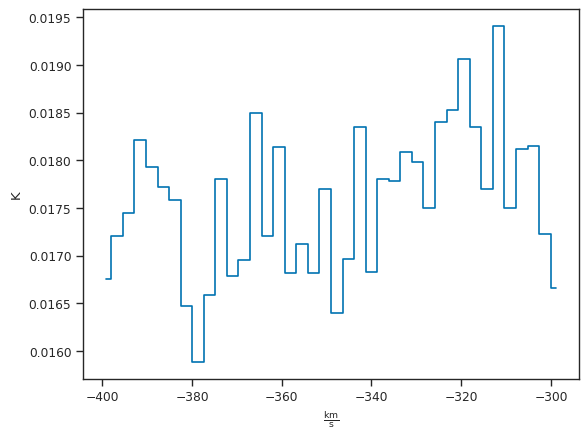

In [363]:
gbt_cube_icrs.spectral_slab(-400*u.km/u.s, -300*u.km/u.s).mad_std(axis=(1, 2)).quicklook()

rms = gbt_cube_icrs.spectral_slab(-400*u.km/u.s, -300*u.km/u.s).mad_std()
print(rms, 5 * rms)

In [373]:
# Subtract off the Galactic HI model:
gbt_cube_ngc6822only = gbt_cube_icrs - gbt_cube_cloudclean

# Incorporate some masking for the most significant residual "holes" remaining near 0 km/s
interp_mask = (gbt_cube_ngc6822only > -5 * rms).include()
# Erode the mask a bit to get most of the hole regions
# for this_chan in range(interp_mask.shape[0]):
#     interp_mask[this_chan] = nd.binary_erosion(interp_mask[this_chan], np.ones((3, 3), bool))

gbt_cube_ngc6822only = gbt_cube_ngc6822only.with_mask(interp_mask)

Did it work?

Compare some moment maps:

/home/erickoch/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/home/erickoch/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/home/erickoch/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


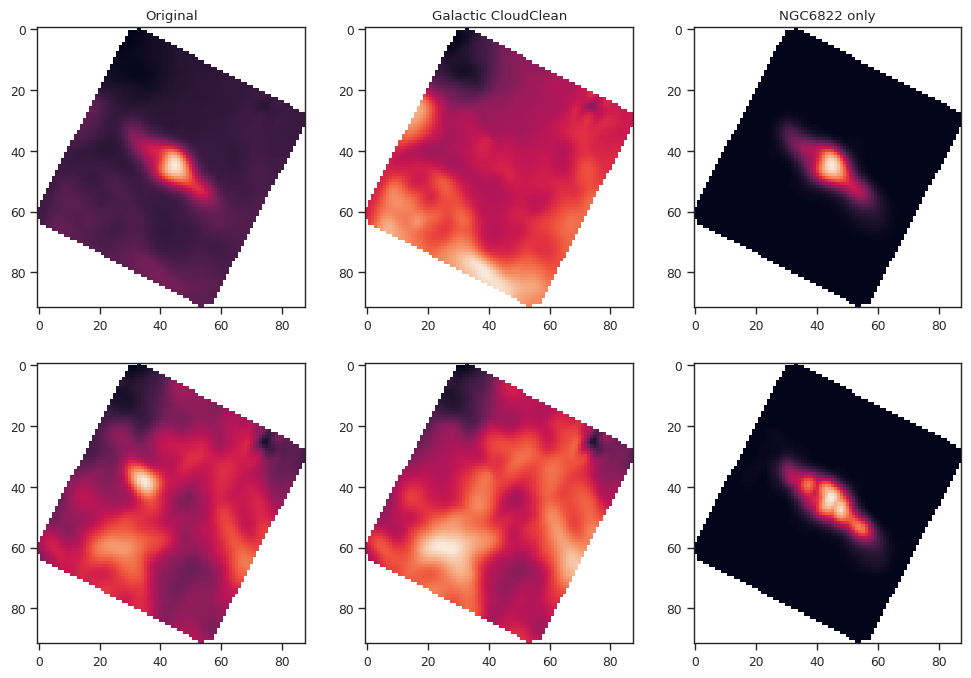

In [374]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].set_title("Original")
axs[0,0].imshow(gbt_cube_icrs.moment0().value)

axs[0, 1].set_title("Galactic CloudClean")
axs[0, 1].imshow(gbt_cube_cloudclean.moment0().value)

axs[0, 2].set_title("NGC6822 only")
axs[0, 2].imshow(gbt_cube_ngc6822only.moment0().value)

axs[1, 0].imshow(gbt_cube_icrs.max(0).value)
axs[1, 1].imshow(gbt_cube_cloudclean.max(0).value)
axs[1, 2].imshow(gbt_cube_ngc6822only.max(0).value)

# axs[1, 0].imshow(gbt_cube_icrs.moment1().value, cmap='coolwarm')
# axs[1, 1].imshow(gbt_cube_cloudclean.moment1().value, cmap='coolwarm')
# axs[1, 2].imshow(gbt_cube_ngc6822only.with_mask(gbt_cube_ngc6822only > 1 * u.K).spectral_slab(-80*u.km/u.s, 20*u.km/u.s).moment1().value, cmap='coolwarm')

# gbt_cube_cloudclean.moment0().quicklook()

/home/erickoch/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


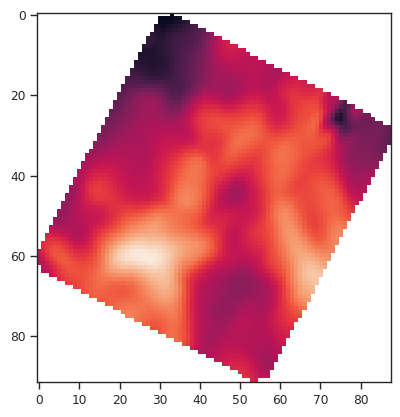

In [375]:
gbt_cube_cloudclean.max(0).quicklook()

/home/erickoch/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


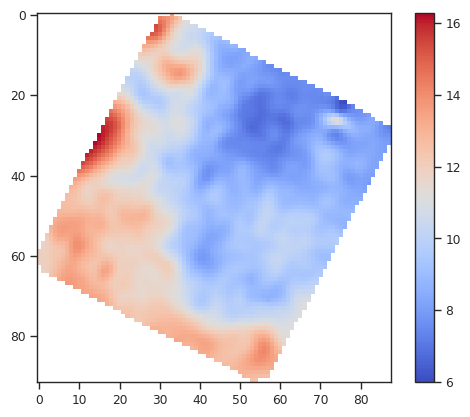

In [376]:
plt.imshow(gbt_cube_cloudclean.moment1().value, cmap='coolwarm')
plt.colorbar()

/home/erickoch/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


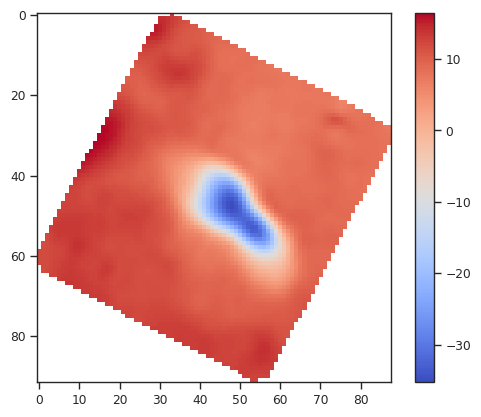

In [377]:
plt.imshow(gbt_cube_icrs.moment1().value, cmap='coolwarm')
plt.colorbar()

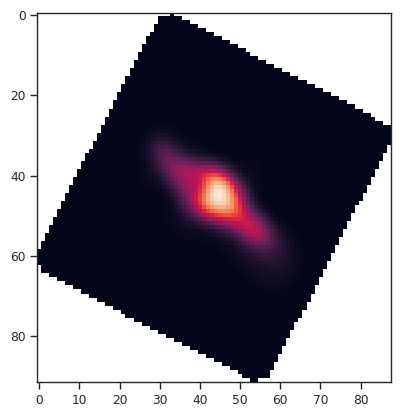

In [378]:
gbt_cube_ngc6822only.moment0().quicklook()

/home/erickoch/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


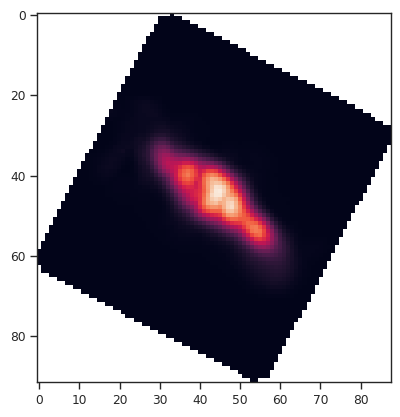

In [379]:
gbt_cube_ngc6822only.max(0).quicklook()

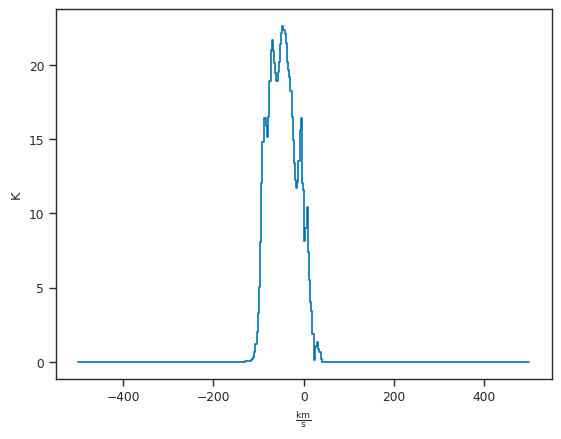

In [380]:
# gbt_cube_icrs.mean(axis=(1, 2)).quicklook()

gbt_cube_ngc6822only.max(axis=(1, 2)).quicklook()
# gbt_cube_cloudclean.mean(axis=(1, 2)).quicklook()


Maybe a couple channels with some instability, but remarkably good nonetheless.

Upon further inspection, this is due to the bright HI foreground near 0 km/s, and the broad mask we're using means that small fluctuations relative to the mean remain highly significant when taking the difference.

We can likely alleviate this by shrinking the mask area for the channels near 0 km/s.


In [381]:
gbt_cube_ngc6822only.write(sd_data_path / "NGC6822-center_cube_ircs_no_galactic_component.fits", overwrite=True)